In [83]:
import warnings
warnings.filterwarnings("ignore")

# loading packages

import numpy as np
import pandas as pd
from pandas import datetime
from pandas import Series,DataFrame
import matplotlib.pyplot as plt


from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from urllib.parse import urlparse

import mlflow
import mlflow.sklearn
import scipy.stats as scs
import statsmodels.api as sm

import logging

import dvc.api

In [60]:
Format = '%(levelname)s %(asctime)s - %(message)s'
logging.basicConfig(filename= r'C:\Users\Jakinda\Documents\Python Scripts\10Academy\PharmaceuticalSalesPrediction\Notebook\ml.log',
level =logging.INFO,
format = Format)
logger = logging.getLogger()

In [61]:
mlflow.set_experiment('pharma sales')

In [62]:
#Get url from DVC

path = r'C:\Users\Jakinda\Documents\Python Scripts\10Academy\PharmaceuticalSalesPrediction\data\store.csv'
repo = r'C:\Users\Jakinda\Documents\Python Scripts\10Academy\PharmaceuticalSalesPrediction'
version = 'v3'

data_url = dvc.api.get_url(

    path = path,
    repo = repo,
    rev = version

)


In [63]:
store = pd.read_csv(data_url,sep=',')
store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [64]:
path = r'C:\Users\Jakinda\Documents\Python Scripts\10Academy\PharmaceuticalSalesPrediction\data\train.csv'
repo = r'C:\Users\Jakinda\Documents\Python Scripts\10Academy\PharmaceuticalSalesPrediction'
version = 'v1'

data_url2 = dvc.api.get_url(

    path = path,
    repo = repo,
    rev = version

)

In [65]:
train = pd.read_csv(data_url2,sep=',')
train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [ ]:
mlflow.set_experiment('pharma_test')

In [66]:
mlflow.log_param("data_url", data_url)
mlflow.log_param("data_version", version)
mlflow.log_metric("input_rows", train.shape[0])
mlflow.log_metric("input_cols", train.shape[1])

In [67]:
mlflow.log_param("data_url", data_url)
mlflow.log_param("data_version", version)
mlflow.log_metric("store_input_rows", store.shape[0])
mlflow.log_metric("store_input_cols", store.shape[1])

In [68]:
# merge the train with the stores set
train_store = pd.merge(left = train, right = store, how = 'inner', left_on = 'Store', right_on = 'Store')
print(train_store.shape)
#print(test_store.shape)

(1017209, 18)


In [69]:

mlflow.log_metric("input_rows", train_store.shape[0])
mlflow.log_metric("input_cols", train_store.shape[1])

In [70]:
train_store = train_store.drop(columns=['Customers','Store'])

target_name = "Sales"
target = train_store[target_name]

data = train_store.drop(columns=[target_name])

In [71]:
def feature_generation(data):
    data['Date'] = pd.to_datetime(data.Date)
    data['Month'] = data.Date.dt.month.to_list()
    data['Year'] = data.Date.dt.year.to_list()
    data['Day'] = data.Date.dt.day.to_list()
    data['WeekOfYear'] = data.Date.dt.weekofyear.to_list()
    data['DayOfWeek'] = data.Date.dt.dayofweek.to_list()
    data['weekday'] = 1        # Initialize the column with default value of 1
    data.loc[data['DayOfWeek'] == 5, 'weekday'] = 0
    data.loc[data['DayOfWeek'] == 6, 'weekday'] = 0
#         data = data.drop(['Date'], axis = 1)
        
    return data

In [72]:
data = train_dup=feature_generation(data)

In [73]:
data = data.drop(columns='Date')
data

,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month,Year,Day,WeekOfYear,weekday
0,4,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,7,2015,31,31,1
1,3,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,7,2015,30,31,1
2,2,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,7,2015,29,31,1
3,1,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,7,2015,28,31,1
4,0,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,7,2015,27,31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,5,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",1,2013,5,1,0
1017205,4,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",1,2013,4,1,1
1017206,3,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",1,2013,3,1,1
1017207,2,1,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",1,2013,2,1,1


In [74]:
data["StateHoliday"] = data["StateHoliday"].map({0: 0, "0": 0, "a": 1, "b": 1, "c": 1})

In [75]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

In [76]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42)

In [78]:
cont_pipeline = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy = 'median')),
    ('power',PowerTransformer(method = 'yeo-johnson', standardize = False)),
    ('scaler',StandardScaler())
]
)

In [79]:
cat_pipeline = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy = 'most_frequent', fill_value = 'unknown')),
    ('onehot',OneHotEncoder(handle_unknown="ignore"))]
)

In [80]:
preprocessor = ColumnTransformer(
    transformers = [
        ('continuous', cont_pipeline, numerical_columns),
        ('categorical', cat_pipeline, categorical_columns)

    ]
)

In [81]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def calculate_metrics(y_test, y_preds):
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    r_sq = r2_score(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)

    return rmse,r_sq,mae

In [84]:
def quick_eval(pipeline, X_train, y_train, X_test, y_test, verbose=True):
    """
    Quickly trains modeling pipeline and evaluates on test data.      Returns original model, training RMSE, and testing
    RMSE as a tuple.
    """
    
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    train_score = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_score = np.sqrt(mean_squared_error(y_test, y_test_pred))
    (rmse, r_sq, mae)=calculate_metrics(y_test, y_test_pred)

    if __name__ == "__main__":
    
        if verbose:
            print(f"Regression algorithm: {pipeline.named_steps['regressor'].__class__.__name__}")
            logger.info(f"Regression algorithm: {pipeline.named_steps['regressor'].__class__.__name__}")
            print(f"Train RMSE: {train_score}")
            logger.info(f"Train RMSE: {train_score}")
            print(f"Test RMSE: {test_score}")
            logger.info(f"Test RMSE: {test_score}")

            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("r_sq", r_sq)
            mlflow.log_metric("mae", mae)

            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

             # Model registry does not work with file store
            if tracking_url_type_store != "file":

                # Register the model
                # There are other ways to use the Model Registry, which depends on the use case,
                # please refer to the doc for more information:
                # https://mlflow.org/docs/latest/model-registry.html#api-workflow
                mlflow.sklearn.log_model(pipe, f"{pipeline.named_steps['regressor'].__class__.__name__}", registered_model_name=f"{pipeline.named_steps['regressor'].__class__.__name__}")
            else:
                mlflow.sklearn.log_model(pipe, f"{pipeline.named_steps['regressor'].__class__.__name__}")
                print("Model saved in run %s" % mlflow.active_run().info.run_uuid)
                #stop
                
        
        return pipeline.named_steps['regressor'], train_score, test_score
            
    
regressors = [
    DecisionTreeRegressor(),
    LinearRegression(),
    GradientBoostingRegressor(),
    RandomForestRegressor()
]
for r in regressors:
    pipe = Pipeline(steps = [
        ('preprocessor', preprocessor),
        ('regressor', r)
    ])

    quick_eval(pipe, data_train, target_train, data_test, target_test)
    print()


Regression algorithm: DecisionTreeRegressor
Train RMSE: 105.94869640760602
Test RMSE: 1222.8547203764906
Model saved in run ca272af0f1234de89cc539660ca6134f

Regression algorithm: LinearRegression
Train RMSE: 2508.251324525623
Test RMSE: 2497.660038032195
Model saved in run ca272af0f1234de89cc539660ca6134f

Regression algorithm: GradientBoostingRegressor
Train RMSE: 2237.3661012422194
Test RMSE: 2230.8655035374786
Model saved in run ca272af0f1234de89cc539660ca6134f



In [ ]:
from sklearn import set_config
set_config(display='diagram')
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('power',
                                                                   PowerTransformer(standardize=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['DayOfWeek', 'Open', 'Promo',
                                                   'StateHoliday',
                                                   'SchoolHoliday',
                                                   'CompetitionDistance',
                                                   'CompetitionOpenSinceMonth',
                                                   'CompetitionOpenSinceYear',
                                                   'Promo2', 'Promo2SinceWeek',
                                                   'Promo2SinceYear', 'Month',
                                                   'Year', 'Day', 'WeekOfYear',
                                                   'weekday']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['StoreType', 'Assortment',
                                                   'PromoInterval'])])),
                ('regressor', RandomForestRegressor())])

In [ ]:
rf = regressors [3]

In [ ]:
rfimp = rf.feature_importances_
rfimp 

array([3.25478932e-02, 4.60344870e-01, 7.31524116e-02, 6.85998088e-04,
       3.62923675e-03, 1.48275593e-01, 4.94290336e-02, 5.71606163e-02,
       1.07073569e-02, 2.17520424e-02, 1.43050116e-02, 1.07104357e-02,
       9.00782257e-03, 2.51971735e-02, 2.15595185e-02, 3.99211646e-03,
       9.24052532e-03, 1.33695879e-02, 6.91560639e-03, 5.16064811e-03,
       5.99934744e-03, 3.29778782e-04, 8.07894641e-03, 2.05174038e-03,
       2.65052168e-03, 3.74616650e-03])

In [ ]:
feature_name =pipe.named_steps['preprocessor'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(categorical_columns)
feature_name

array(['StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_a', 'Assortment_b', 'Assortment_c',
       'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct',
       'PromoInterval_Mar,Jun,Sept,Dec'], dtype=object)

In [ ]:
fnames = ['DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Month', 'Year',
       'Day', 'WeekOfYear', 'weekday','StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_a', 'Assortment_b', 'Assortment_c',
       'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct',
       'PromoInterval_Mar,Jun,Sept,Dec']

In [ ]:
zipped = zip(fnames, rfimp)
df = pd.DataFrame(zipped, columns=["feature", "value"])
df = df.sort_values(by = 'value',ascending=False)
df= df.set_index('feature')
df

,value
feature,
Open,0.460345
CompetitionDistance,0.148276
Promo,0.073152
CompetitionOpenSinceYear,0.057161
CompetitionOpenSinceMonth,0.049429
DayOfWeek,0.032548
Day,0.025197
Promo2SinceWeek,0.021752
WeekOfYear,0.021560


<AxesSubplot:xlabel='feature'>

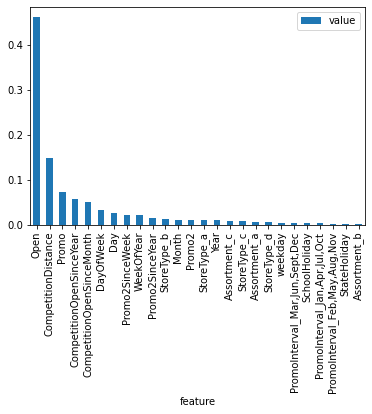

In [ ]:
df.plot.bar()

In [ ]:
'''pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor)
        ]
        )'''

In [ ]:
#pipe.fit(data_train,target_train)

In [ ]:
'''feature_name =pipe.named_steps['preprocessor'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(categorical_columns)
feature_name'''

In [ ]:
#data_train.columns 

In [ ]:
'''fnames = ['DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Month', 'Year',
       'Day', 'WeekOfYear', 'weekday','StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_a', 'Assortment_b', 'Assortment_c',
       'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct',
       'PromoInterval_Mar,Jun,Sept,Dec']'''

In [ ]:
#imp = pipe.named_steps["regressor"].feature_importances_

In [ ]:
'''zipped = zip(fnames, imp)
df = pd.DataFrame(zipped, columns=["feature", "value"])
df = df.sort_values(by = 'value',ascending=False)
df= df.set_index('feature')
df'''

In [ ]:
#df.plot.bar()

In [ ]:
'''for r in regressors:
    if r == regressors[1]:
        print('hello')
    else:
        importance = r.feature_importances_
        '''

hello


Making a pipeline with randomForest

In [ ]:
model = make_pipeline(preprocessor, RandomForestRegressor())

In [ ]:
from sklearn import set_config
set_config(display='diagram')
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('powertransformer',
                                                                   PowerTransformer(standardize=False)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['DayOfWeek', 'Open', 'Promo',
                                                   'StateHoliday',
                                                   'SchoolHoliday',
                                                   'CompetitionDistance',
                                                   'CompetitionOpenSinceMon...
                                                   'Promo2', 'Promo2SinceWeek',
                                                   'Promo2SinceYear', 'Month',
                                                   'Year', 'Day', 'WeekOfYear',
                                                   'weekday']),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='unknown',
                                                                                 strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['StoreType', 'Assortment',
                                                   'PromoInterval'])])),
                ('randomforestregressor', RandomForestRegressor())])